# 1. Исследовательский анализ данных

Found 7591 validated image filenames.


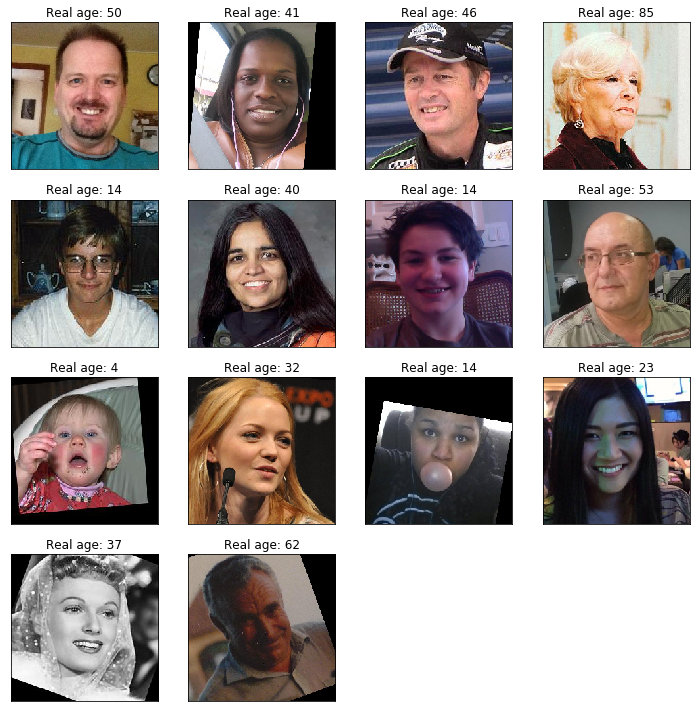

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

features, target = next(train_gen_flow)

# выводим 14 изображений
fig = plt.figure(figsize=(10,10))
for i in range(14):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Real age: ' + str(target[i]))
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

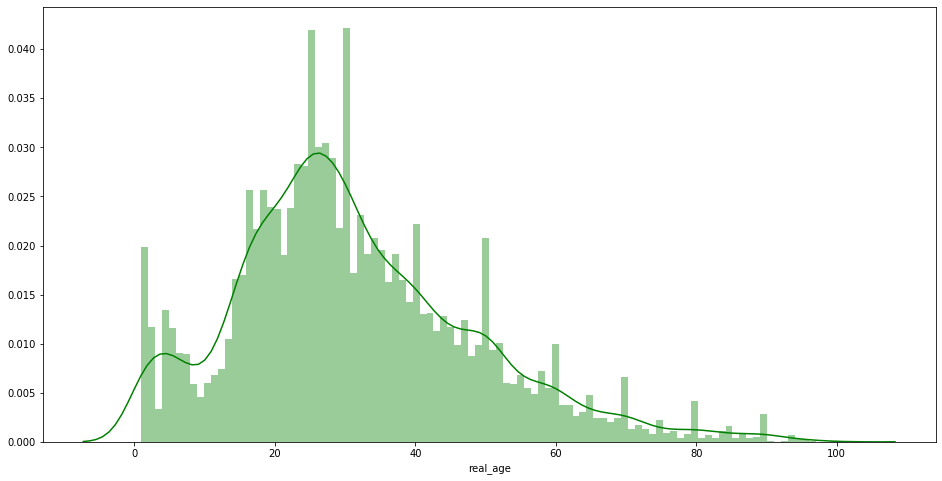

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16,8))
sns.distplot(labels['real_age'], kde = True,  bins=labels.real_age.max(), color="g")

###  Вывод
1. По выборке из 14 фотографий видим, что датасет неоднородный - представлены фото людей разных национальностей, возрастов, цвета кожи, в анфас и профиль, некоторые фото повернуты, и есть черно-белые и ретро.
2. По гистограмме можно сказать, что в целом возраст распределен нормально со скошенностью вправо. Больше всего фото с возрастом от 25 до 30 лет. Видим большое количества фотографий детей до 10 лет. Для всех фото есть склонность к округлению возраста( 30, 40, 50 и т.д. лет), с увеличение возраста это усиливается. Так же опасность есть с возрастом от 60 лет, т.к. фотографий людей старшего возраста для обучения не так много, модель может плохо определять старший возраст по фотографии. Но большинство фотографий, передаваемых в сеть, принадлежат людям среднего возраста, поэтому общее качество прогноза не должно сильно пострадать.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'), 
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe =  pd.read_csv(path + 'labels.csv'), 
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=len(train_data),
              validation_steps=len(test_data),
              verbose=2)
  
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-02-16 12:09:24.885819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-16 12:09:25.233713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 51s - loss: 190.6546 - mae: 10.2685 - val_loss: 352.5623 - val_mae: 13.9660
Epoch 2/10
178/178 - 41s - loss: 104.4046 - mae: 7.7889 - val_loss: 419.2864 - val_mae: 15.4439
Epoch 3/10
178/178 - 41s - loss: 86.8591 - mae: 7.0227 - val_loss: 454.4739 - val_mae: 16.2031
Epoch 4/10
178/178 - 41s - loss: 67.9718 - mae: 6.2493 - val_loss: 293.9411 - val_mae: 12.6129
Epoch 5/10
178/178 - 41s - loss: 54.1479 - mae: 5.6159 - val_loss: 125.0584 - val_mae: 8.4542
Epoch 6/10
178/178 - 41s - loss: 46.6919 - mae: 5.1724 - val_loss: 100.1373 - val_mae: 7.4236
Epoch 7/10
178/178 - 41s - loss: 37.6041 - mae: 4.7033 - val_loss: 127.1970 - val_mae: 8.8840
Epoch 8/10
178/178 - 41s - loss: 32.6499 - mae: 4.3527 - val_loss: 78.3401 - val_mae: 6.6086
Epoch 9/10
178/178 - 41s - loss: 27.3334 - mae: 3.9735 - val_loss: 82.4412 - val_mae: 6.6939
Epoch 10/10
178/178 - 41s - loss: 21.2419 - mae: 3.5456 - val_loss: 81.0272 - val_mae: 6.6179
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 81.0272 - mae: 6.6179
Test MAE: 6.6179

```

# 3. Анализ обученной модели

1. Загрузил и изучил данные. 
2. В модели была использована предобученная нейросеть ResNet50. Задал 10 эпох, при этом на 8 эпохе метрика MAE опустилась ниже восьми единиц, что требовалось по заданию. Итоговое значение метрики 6.6179, это полностью удовлетворяет условию задания.
3. Мы можем достаточно точно определить возраст покупателя по фотографии, но для контроля продажи алкоголя ошибка в 7 лет в ряде случаев может быть критичной. Возможно понадобятся дополнительные меры контроля, или установить, например, для модели возраст 25 лет как лимит, ниже которого будет выводиться предупреждение. 